In [35]:
import matplotlib.pyplot as plt
from matplotlib import mlab, rcParams
%matplotlib inline
import numpy as np
from scipy import interpolate, spatial
import datetime
from shapely.geometry import Polygon, Point

In [ ]:
def lagcorr(data, tau):
    rho = 0.*np.array(tau)
    for ind,t in enumerate(tau):
        if t > 0:
            rho[ind] = np.nanmean(data[t:]*data[:-t])  # nanmean necessary?
            rho[ind] = rho[ind] / np.nanvar(data[t:-t])  # nanvar?
        else:
            rho[ind] = np.nanmean(data*data)
            rho[ind] = rho[ind] / np.nanvar(data)
    return rho

# Minute data

Temperature data with one-minute resolution is provided from four schools in the format of decimal days as discussed below and the second column is temperature in degrees Celcius.

Present the data, and characterize it using techniques discussed in class. Obvious things to do are just plot the time series, find means, PDFs, spectra. More involved projects will present correlations between the different stations (thats why you have 4!). What differences and patterns can you find between the four stations, and can you explain using your knowledge of the local climate?

In [2]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/kawebb/P411_git/MinuteData/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JohnMuirNew.txt', usecols=([1]), unpack=True)
uv = np.loadtxt('/Users/kawebb/P411_git/MinuteData/UVicISCNew.txt', usecols=([1]), unpack=True)

- john muir - hourdata 15
- james bay - hourdata 14
- uvic - hourdata 32
- deep cove - hourdata 6

In [3]:
# fill in nan values with linear interpolation
# THIS DOESNT SEEM TO WORK WITH THE FOURIER TRANSFORM

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

dc = interp(dc)
jb = interp(jb)
jm = interp(jm)
uv = interp(uv)

# remove mean
dc -= np.mean(dc)
jb -= np.mean(jb)
jm -= np.mean(jm)
uv -= np.mean(uv)

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [30]:
### Power spectral density
### Cross spectral density

Nfft = 2048*12
dt = 60.   # SI THIS CORRECT?
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

def specdensity(x, args, y=None):
    px, f = mlab.psd(x, **args)
    if y is not None:
        py, f = mlab.psd(y, **args)
        pxy, ff = mlab.csd(x, y, **args)
        return px, py, pxy, f
    else:
        return px, f
    
Pdc, Pjb, Pdcjb, f = specdensity(dc, args, jb)
Pjm, Pun, Pjmuv, f = specdensity(jm, args, uv)

Pdcjm, ff = mlab.csd(dc, jm, **args)
Pdcuv, ff,  = mlab.csd(dc, uv, **args)
Pjbjm, ff = mlab.csd(jb, jm, **args)
Pjbuv, ff = mlab.csd(jb, uv, **args)

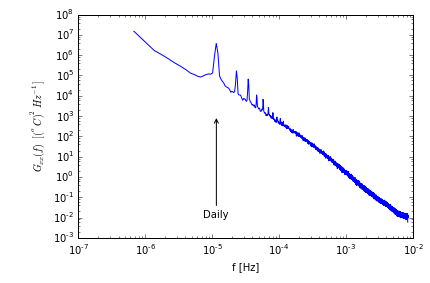

In [31]:
plt.loglog(f, Pdc)

yr = 3600.*24.*365.
day = 3600.*24.
plt.annotate('Annual', xy=(1./yr, 1.e3),  xycoords='data', xytext=(1./yr, 1.e-2), 
             textcoords='data', horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('Daily', xy=(1./day, 1.e3),  xycoords='data', xytext=(1./day, 1.e-2), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.xlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$') ; plt.show()

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

### hanning window doesnt sample low frequency, which is why you dont see the yearly peak

# Hourly data

Then use this data set to look for spatial patterns of variability between the stations (i.e. calculate the Emperical Orthonormal Eigienfunctions, or Principal Components). Plot the strongest modes of variability and indicate what fraction of the variance they represent. Plotting time series of the modal amplitudes is also very effective way of thinking about the system.

Again, spend a couple of paragraphs explaining the patterns you found, and indicate if those patterns might have a physical meaning. Looking at the seasonality of the amplitudes may help.

## ideas:
- temperature differences inland vs coasts, seasonal
- seasonal variances
- east west
- yearly fluctuations
- interpolated missing data points from nearest neighbours

### power spactra
- correlations every 24h, 1yr etc
  - combine spectra to reduce noise and get  clearer peak
  - bandpass filtering
- variation in temperature (amplitude) varies more in summer than winter
- average summer temperature, winter, yearly -> linear equation, fit to majority of data

### to keep in mind:
- more data on coast than inland, how to keep track of percision?

# in polygon function
- use coastline to set limits on 2d interpolation

In [2]:
# Coastline
# 1 degree of latitude is 60 nautical miles, but 1 degree of longitude is only 60*cos(lat) 
# nautical miles, so it is useful to scale your x and y axis so the aspect ratio is 
# [1 cos(lat)], where "lat" is some latitude that is on the center of your plot. This area 
# is small enough that this approximation will be good enough - for larger areas you need 
# to choose a projection from a sphere onto a map (i.e. the "Mercator", "Azimuthal" etc projections).
coastfile = '/Users/kawebb/P411_git/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]

In [3]:
# Hourly data, many stations
# One-hour resolution temperature data is taken from the same network of 35 stations. 
# Data is on an even time grid, from 2009-01-01 08:00 UTC, with each row representing 
# a time, and each column a station. The first two rows are the longitude (degrees E) 
# and latitude (degrees N) of each station.
hourfile = '/Users/kawebb/P411_git/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

In [4]:
### Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

### First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

### Handling nan values, identifying stations with not enough data

/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


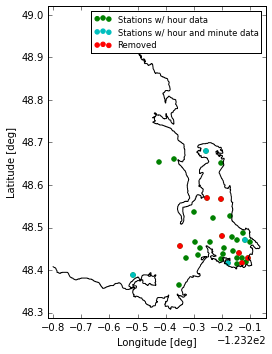

In [5]:
### Plot stations, label those with hour data, minute data, and which we remove

#latexify()
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='o', color='g', label='Stations w/ hour data')
i=[6, 15, 14, 32]
axs.scatter(lng[i], lat[i], marker='o', color='c', label='Stations w/ hour and minute data')
ix = [0, 11, 16, 19, 22, 23, 34]
axs.scatter(lng[ix], lat[ix], marker='o', color='r', label='Removed')

axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
axs.set_xlim(np.min(cstlng)-0.02, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, np.max(cstlat)+0.02)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(fontsize='small')
plt.savefig('figures/map_stations.png')
plt.show()

In [6]:
### Ignore data missing long spans of time

# 0, 11, 16, 19, 22, 23, 34 - missing lots
# 8, 10, 14, 17, 25, 30, 31 - missing a few months maybe

# Valid stations
ii = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
data = data[ii,:]
lng = lng[ii]
lat = lat[ii]

tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def interp_nn(data, coords, tree, radius):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
        nans = np.where(np.isnan(data[i]))
        if len(nans) > 0:
            data[i,:] = interp(data[i,:])
    return data

data = interp_nn(data, coords, tree, radius)
### REMOVE MEAN ????

/Users/kawebb/venv/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


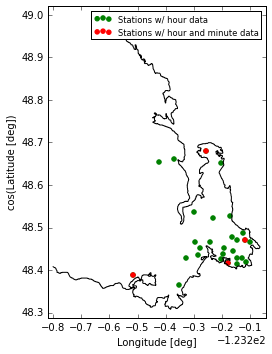

In [7]:
#latexify()
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='o', color='g', label='Stations w/ hour data')
i = [5, 12, 13, 26]  # deep cove, james bay, john muir, uvic
axs.scatter(lng[i], lat[i], marker='o', color='r', label='Stations w/ hour and minute data')

axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'cos(Latitude [deg])')
axs.set_xlim(np.min(cstlng)-0.02, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, np.max(cstlat)+0.02)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(fontsize='small')
#plt.savefig('map_stations.png')
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x10ef040e0>

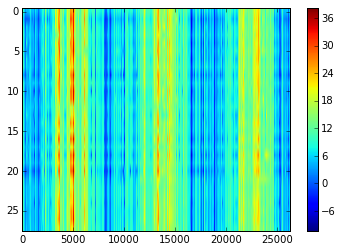

In [8]:
plt.imshow(data, aspect='auto')
plt.colorbar()

## 2D Interpolations

In [ ]:
# Make grid - Smallest distance between points is lateral, 0.234 deg
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

# Set coordinates over water to nan
poly = Polygon(np.dstack([cstlng, cstlat])[0])


mask = np.zeros_like(gridx)
for i,xx in enumerate(xi):
    for j,yy in enumerate(yi):
        point = Point(xx, yy)
        if poly.contains(point):
            mask[i,j] = np.nan


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

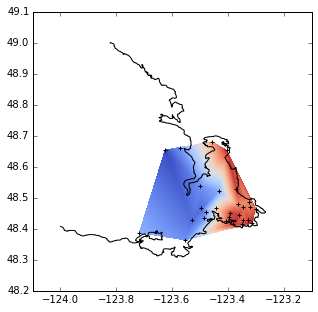

In [28]:
#latexify()

# Make grid - Smallest distance between points is lateral, 0.234 deg
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

z = data[:,1]  # one measurement for all stations

def temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, temp):
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.plot(cstlng, cstlat, '-k')
    pcm = plt.pcolormesh(gridx, gridy, np.ma.masked_invalid(temp), cmap='coolwarm')
    axs.scatter(lng, lat, marker='+', color='k')
    line=1.*lat
    
    axs.fill_between(lng,lat,line,facecolor=(0.8,0.8,0.8),linewidth=0.0,linestyle='dotted',color='grey')
    axs.fill_between((lng-0.001,-123.2),48.2,49,facecolor=(0.8,0.8,0.8),color=(0.8,0.8,0.8))
    axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
    axs.set_xlim(np.min(cstlng)-0.02, np.max(cstlng)+0.02)
    axs.set_ylim(np.min(cstlat)-0.02, np.max(cstlat)+0.02)
    
    axs.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

zi = mlab.griddata(lng, lat, z, xi, yi, interp='linear')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi)

zi = interpolate.griddata(np.vstack((lng,lat)).T, z, (gridx,gridy), method='cubic')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi)


In [18]:
m = Basemap(width=1000,height=1000,projection='lcc',resolution='c',lat_1=48.,lat_2=49,lat_0=48.5,lon_0=-123.5)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')

NameError: name 'Basemap' is not defined

### Power spectral density

In [27]:
### Power spectral density
### Cross spectral density

Nfft = 2048*2
dt = 60.   # IS THIS CORRECT?
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

fps = np.zeros((data.shape[0], Nfft/2+1))
ps = np.zeros((data.shape[0], Nfft/2+1))
for i in range(data.shape[0]):
    ps[i,:], fps[i,:] = mlab.psd(data[i,:], **args)
    
    
#Pdcjm, ff = mlab.csd(dc, jm, **args)

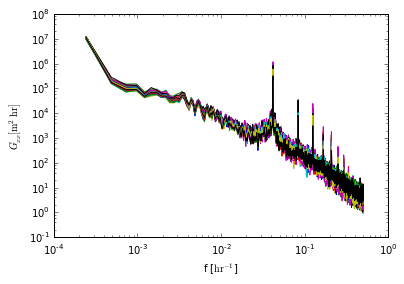

In [28]:
fig,ax=plt.subplots(1,1)
ax.loglog(f, ps.transpose())
plt.xlabel('f [$\mathrm{hr^{-1}}$]');
plt.ylabel(r'$G_{xx} \mathrm{[m^2 hr]}$')

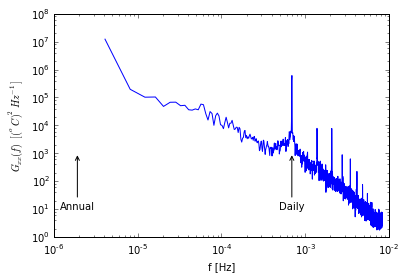

In [11]:
plt.loglog(fps[0,:], ps[0,:])

yr = 60.*24.*365.
day = 60.*24.
plt.annotate('Annual', xy=(1./yr, 1.e3),  xycoords='data', xytext=(1./yr, 1.e1), 
             textcoords='data', horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('Daily', xy=(1./day, 1.e3),  xycoords='data', xytext=(1./day, 1.e1), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))

plt.xlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$') ; plt.show()

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

In [ ]:
pxy,f=mlab.csd(x,y,**args)
gammasq = np.abs(pxy)**2/px/py
pha = np.angle(pxy)

## Look for spatial patterns in the data using empiracle orthogonal functions

### 2d plot temperature as modes

In [12]:
len(data[0,:])

26277

In [ ]:
y = data

C = np.cov(y.T)
Cp, E = np.linalg.eig(C)

for i in range(np.shape(E)[1] ):
    ii = np.argmax(np.abs(E[:,i]))
    E[:,i]=E[:,i]/E[ii,i]

E = E / np.max(np.abs(E),axis=0)
modes=np.dot(np.linalg.inv(E),y)


def plotit():
    fig,ax=plt.subplots(1,1)
    col=['b','g','r','c']
    for m in range(4):
        ax.plot(x,E[:,m],label='mode %d'%m,color=col[m])
    ax.legend(fontsize='small')
    plt.title('Mode shapes')
    plt.xlabel('x [m]')
    plt.ylabel('Emperical Mode shape')
    return fig,ax


In [ ]:
modes

## Spectrogram

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


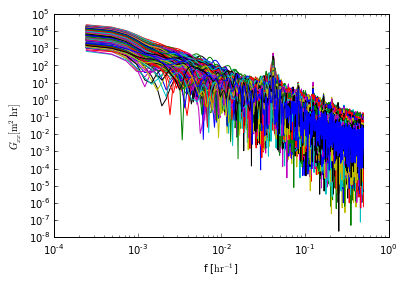

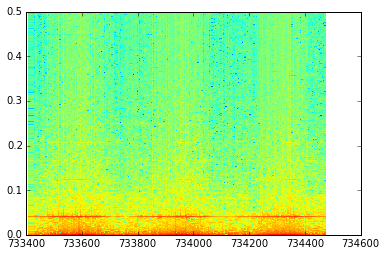

In [30]:
N = data.shape[1]
t = np.arange(N)
dt2 = np.median(np.diff(t))
NN = 24.  # This is just the window size, for small window size, remove high f ?
n = int(np.floor(N/NN))
nn = 10.  # ??????

gxx = np.zeros((N*nn, Nfft/2+1))
tbin = np.zeros(N*nn)

num = 0

temp = data[0,:]
args2 = {'NFFT':Nfft, 'Fs':1./dt2, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

for idx in np.arange(0, N-n, int(np.floor(n/nn))):
    px, f = np.squeeze( mlab.psd(temp[idx+np.arange(n)], **args2))
    gxx[num,:] = px
    num += 1
    tbin[num] = np.mean(t[idx+np.arange(n)])

tbin = tbin[:num]
gxx = gxx[:num, :]

fig,axs = plt.subplots(1,1)
axs.loglog(f, gxx.transpose())
axs.set_xlabel('f [$\mathrm{hr^{-1}}$]')
axs.set_ylabel(r'$G_{xx} \mathrm{[m^2 hr]}$')
plt.show()


fig,axs = plt.subplots(1,1)
pcm = axs.pcolormesh(tbin/24.+733408.0, f, np.log10(gxx.transpose()))
plt.show()

In [ ]:
### Lag correlation coefficient - Assignment 3

lag = np.arange(0,30*24)

rho = lagcorr(dc, lag)

x = lag/24.
plt.plot(x, rho)
plt.xlabel(r'$\tau [days]$') ; plt.ylabel(r'$\rho_{xy}(\tau)$') ; plt.show()

# There is a strong daily correlation, superimposed on a longer time scale 
#  weakening of the correlation as time gets further out.

# Do the same for winter and summer months

## Suggestions

- write a hypothesis
  - apply techniques to prove hypothesis
- plot a power spectrum to find a peak



In [11]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    assert(columns in [1,2])
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches
    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }
    rcParams.update(params)
    
def format_axes(ax, xlabel, ylabel):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    return ax